In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import sklearn.metrics as sk
import os

In [3]:
def cargar_datos(nombre):
    lista_nombres = []
    lista_metodos_matrices=[]
    metodos = os.listdir('./'+nombre)
    for metodo in metodos:
        matrices = pd.read_csv('./'+nombre+'/'+metodo)
        matrices = procesar_input(matrices)
        lista_metodos_matrices.append(matrices)
        metodo = metodo[:-4]
        metodo = metodo.replace('_', ' ')
        aux = metodo.split('-')
        sup = aux[0].split(' ', 1)
        aux = sup + aux[1:]
        lista_nombres.append(aux)
    return(lista_nombres, lista_metodos_matrices)


In [4]:
def procesar_input(matrices_de_confusion):
    lista_matrices  = []
    for i in matrices_de_confusion.index:
        matriz_aux = (matrices_de_confusion.iloc[[i]]).values
        matriz_aux = matriz_aux.reshape(10,10)
        df_matriz = pd.DataFrame(data = matriz_aux)
        lista_matrices.append(df_matriz)
    return lista_matrices

def ver_simetria(matriz):
    matriz = matriz
    matriz_Trans = matriz.transpose()
    return (matriz - matriz_Trans).abs()

def accuracy(mat):
    dividendo = (pd.Series(np.diag(mat), index=[mat.index, mat.columns])).sum()
    aux =  dividendo / (mat.sum()).sum() 
    df = pd.DataFrame([aux], columns = ['accuracy'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

def accuracy_mat(lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, accuracy_aux = accuracy(lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = accuracy_aux
    
    return (desvio, promedio, df)



def precision_clase(mat, clase):
    dividendo = mat.iat[clase, clase]
    divisor = mat[clase].sum()
    return dividendo/divisor

def precision(mat):
    prec = []
    for i in range(10):
        aux = precision_clase(mat,i)
        prec.append(aux)
    df = pd.DataFrame(prec, columns = ['precision'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

#precisionM es el parametro promedio que devolvemos
def precision_mat(lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, precision_aux = precision(lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = precision_aux
    
    return (desvio, promedio, df)

def recall_clase(mat, clase):
    dividendo = mat.iat[clase, clase]
    divisor = mat.iloc[clase].sum()
    return dividendo/divisor
    
def recall(mat):
    rec = []
    for i in range(10):
        aux = recall_clase(mat, i)
        rec.append(aux)
    df = pd.DataFrame(rec, columns = ['recall'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

#RecallM es el parametro promedio que devolvemos
def recall_mat(lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, recall_aux = recall(lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = recall_aux
    
    return (desvio, promedio, df)

def F_score_clase(beta, mat, clase):
    prec = precision_clase(mat, clase)
    rec = recall_clase(mat, clase)
    dividendo = (beta**2 + 1) * prec*rec
    divisor = beta**2 * (prec + rec)
    return dividendo/divisor

def F_score(beta, mat):
    rec = []
    for i in range(10):
        aux = F_score_clase(beta, mat, i)
        rec.append(aux)
    df = pd.DataFrame(rec, columns = ['F'+str(beta)+'_score'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

def F_score_mat(beta, lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, f_score_aux = F_score(beta, lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = f_score_aux
    
    return (desvio, promedio, df)

def F_score_M(beta, lista_mat):
    desvio, precision_M, df = precision_mat(lista_mat)
    desvio, recall_M, df = recall_mat(lista_mat)
    precision_M.index = [0]
    recall_M.index = [0]
    dividendo = (beta**2 + 1)*precision_M * recall_M
    divisor = (beta**2 * precision_M) +recall_M
    return dividendo/divisor

In [35]:
#k_fold lineas donde la linea i es una matriz de confusion de la i_esima iteracion de k_fold
nombres, lista_metodos = cargar_datos('KNN')
nombres_pca, lista_metodos_pca = cargar_datos('KNNPCA')

In [6]:
#bla, bls, df = accuracy_mat(matrices)
#df

In [7]:
#for mat in matrices:
    #sns.heatmap(mat)
    #plt.show()

In [8]:
#prom = matrices[0]
#prom, desvio =  unificar_matrices(matrices)
#sns.heatmap(prom, cmap = "Reds", annot = True)
#plt.yticks(rotation=0)
#plt.show()

#prom2 = matrices[0].copy(deep = True)
#np.fill_diagonal(prom2.values, 0)
#sns.heatmap(prom2)
#plt.yticks(rotation=0)
#plt.show()

In [9]:
#sim = ver_simetria(prom)
#prom_aux = prom.copy(deep = True)
#np.fill_diagonal(prom_aux.values, 0)
#sns.heatmap(data = sim, annot = prom_aux, cmap = "Blues")
#plt.xlabel("predición")
#plt.yticks(rotation=0)
#plt.show()
#print(prom.sum(axis = 1))
#normalizado

La idea de este heatmap es ver si cuando si se confunde de la misma forma, ejempo, tengo una foto de un 5 y me dice que es un 6, quiero ver si cuando mira una foto de un 6 se confunde masomenos la misma cantidad de veces.
Para hacer eso, agarra la matriz y le reste su traspuesta, es decir A(i,j) - A(j, i) cuanto mas cercano a cero es mas similares son las prediciones de ambos lados, si es muy positivo, es por que predice mas veces A(i,j) y cuando es negativo predice mas veces A(j, i).
Lo que nos faltaria ver, para que este grafico este piola, serian los valores reales de cada posicion. Creo que se entiende por que... Si en la posicion A(9,7) esta asi por que en realidad habia un 6 ahi y un 0 en la pos (7,9) entonces es un indicador de que no se confunde de la misma forma el 7 con el nueve que el 9 con el 7... pero si habia 600, eso implica que en la posicion A(7,9) habia 594 y eso diria que se confunden relativamente igual. Hay se ve un poco mejor(dejo esto para que entiendan los numeros y esas cosas)
Saque la diagonal por que... es obvio que da 0 y ensucia un grafico que ya esta bastante cargado.

# Calculamos accuracy para cada metodo


In [44]:
def tags(lista_variables):
    etiqueta = ''
    if lista_variables[0] == 'KNN':
        etiqueta += str(lista_variables[1])
    if lista_variables[0] =='KNNPCA':
        etiqueta += str(lista_variables[1])+'\n'+str(lista_variables[2])
    if lista_variables[0] == 'KNNMODPCA':
        etiqueta += str(lista_variables[2])+'\n'
    etiqueta += '\n'+ str(lista_variables[3])
    return etiqueta

In [79]:
def agregar_columnas(accuracy_total):
    knns = [100 for x in range(len(accuracy_total.index))]
    alphas = [-100 for x in range(len(accuracy_total.index))]
    kfolds = [0 for x in range(len(accuracy_total.index))]
    i = 0
    for ind in accuracy_total.index:
        lista = ind.split("\n")
        lista_piola = []
        for elem in lista:
            aux = elem.split()
            lista_piola.append(aux)
        for tripla in lista_piola:
            alpha = -100
            knn = 100
            kfold = 0
            if tripla[0] == 'k':
                knn = int(tripla[1])
                knns[i] = knn
            elif tripla[0] == 'alpha':
                alpha = int(tripla[1])
                alphas[i] = alpha
            elif tripla[0] == 'kfold':
                kfold = int(tripla[1])
                kfolds[i] = kfold

        i += 1
    accuracy_total['alpha'] = alphas
    accuracy_total['kfold'] = kfolds
    accuracy_total['knn'] = knns

    return accuracy_total

def accuracy_metodos(nombres, lista_metodos):
    i = 0
    accu = []
    etiquetas = []
    for metodo in lista_metodos:
        bla, bls, df = accuracy_mat(metodo)
    
        tag = tags(nombres[i])
        i += 1
        accu.append(df)
        etiquetas.append(tag)
        
    accuracy_total = pd.concat(accu)
    accuracy_total.index = etiquetas
    accuracy_total = agregar_columnas(accuracy_total)
    
    return accuracy_total

def F1_metodos(nombres, lista_metodos):
    i = 0
    f1 = []
    etiquetas = []
    for metodo in lista_metodos:
        df = F_score_M(1, metodo)
        
        tag = tags(nombres[i])
        i += 1
        f1.append(df)
        etiquetas.append(tag)
        
    accuracy_total = pd.concat(f1)
    accuracy_total.index = etiquetas
    accuracy_total = agregar_columnas(accuracy_total)

    return accuracy_total

def graficar_orden_knn(accuracy_total, metrica, metodo, save):
    accuracy_total_knn = accuracy_total.sort_values(['knn','alpha','kfold'], axis = 0)
    accuracy_total_knn.drop(['alpha','kfold','knn'], axis = 1, inplace = True)
    
    cant_grupos = len(accuracy_total_knn.index)//12
    principio = 0
    fin = 12
    
    for i in range(cant_grupos):
        accur = accuracy_total_knn.iloc[principio:fin, :]
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        sns.violinplot(accur.transpose())
        plt.title(metrica+' con '+metodo+'.')

        if(save):
            plt.savefig(metrica+metodo+str(i)+'ordenknn.png')
        plt.show()
        principio = fin
        fin = principio + 12
    
    if principio < len(accuracy_total_knn.index) :
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.title(metrica+' con '+metodo+'.')
        sns.violinplot((accuracy_total_knn.iloc[principio:,:]).transpose())
        if(save):
            plt.savefig(metrica+metodo+'ordenknn.png')
        plt.show()
        
def graficar_orden_alpha(accuracy_total, metrica, metodo, save):
    accuracy_total_knn = accuracy_total.sort_values(['alpha','knn','kfold'], axis = 0)
    accuracy_total_knn.drop(['alpha','kfold','knn'], axis = 1, inplace = True)

    
    cant_grupos = len(accuracy_total_knn.index)//12
    principio = 0
    fin = 12
    for i in range(cant_grupos):
        accur = accuracy_total_knn.iloc[principio:fin, :]
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        sns.violinplot(accur.transpose())
        plt.title(metrica+' con '+metodo+'.')
        if(save):
            plt.savefig(metrica+metodo+str(i)+'ordenalpha.png')
        plt.show()
        principio = fin
        fin = principio + 12
    
    if principio < len(accuracy_total_knn.index) :
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        sns.violinplot((accuracy_total_knn.iloc[principio:,:]).transpose())
        plt.title(metrica+' con '+metodo+'.')
        if(save):
            plt.savefig(metrica+metodo+'ordenalpha.png')
        plt.show()
            
def graficar_orden_kfold(accuracy_total, metrica, metodo, save):
    accuracy_total_knn = accuracy_total.sort_values(['kfold', 'alpha','knn'], axis = 0)
    accuracy_total_knn.drop(['alpha','kfold','knn'], axis = 1, inplace = True)

    
    cant_grupos = len(accuracy_total_knn.index)//12
    principio = 0
    fin = 12
    for i in range(cant_grupos):
        accur = accuracy_total_knn.iloc[principio:fin, :]
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        sns.violinplot(accur.transpose())
        plt.title(metrica+' con '+metodo+'.')
        if(save):
            plt.savefig(metrica+metodo+str(i)+'ordenkfold.png')
        plt.show()
        principio = fin
        fin = principio + 12
        
    if principio < len(accuracy_total_knn.index) :
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        sns.violinplot((accuracy_total_knn.iloc[principio:,:]).transpose())
        plt.title(metrica+' con '+metodo+'.')
        if(save):
            plt.savefig(metrica+metodo+'ordenkfold.png')
        plt.show()


## Accuracy de Knn con distintos hiperparametros

#### Los graficos se ordenan de dos formas, agrupados por el knn y por el kfold

knn
kfold


/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


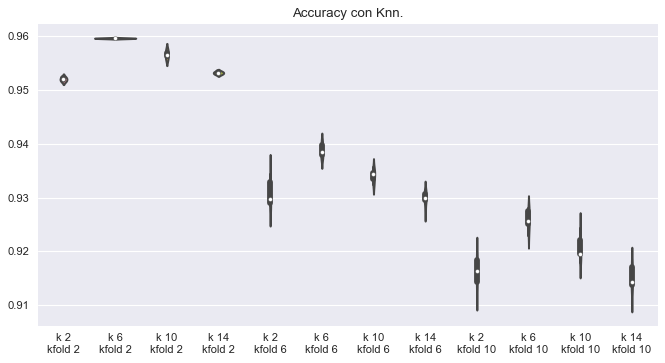

In [80]:

ac = accuracy_metodos(nombres, lista_metodos)
print("knn")
#graficar_orden_knn(ac, "Accuracy", "Knn")
print("kfold")
graficar_orden_kfold(ac, "Accuracy", "Knn", True)

Podemos ver, dos cosas, la primera es que el knn que nos conviene es el k = 6, ya que en cada kfold esta por arriba de los otros. La segunda es que no importa que knn eligamos todos los metodos tienen una accuracy decreciente por el tamaño del kfold, esto es un comportamiento extremadamente extraño.

# Accuracy de Knn con PCA, para distintos parametros.

### como tenemos muchos metodos, van a haber muchisimos graficos, vamos separar los datos en distintos knn y despues vamos a graficar con dos ordenes, el alpha y el kfold.

[14  2  6 10]
knn: 14
alpha


/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


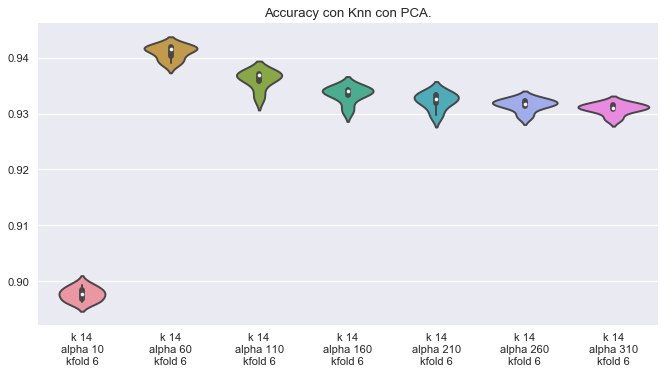

knn: 2
alpha


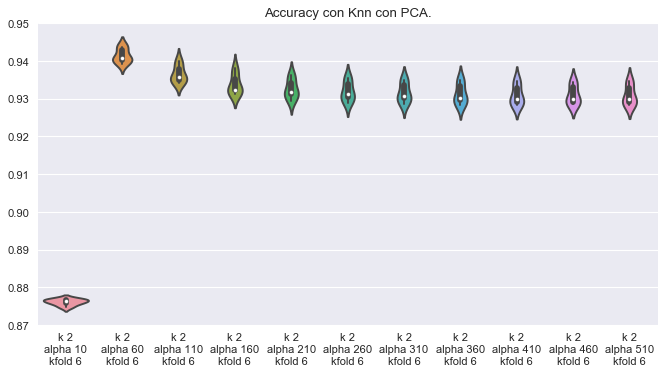

knn: 6
alpha


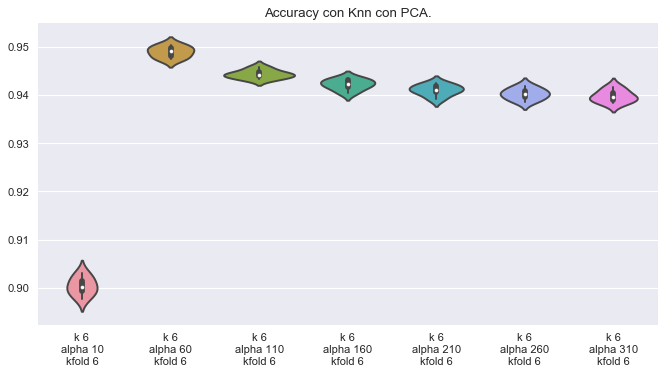

knn: 10
alpha


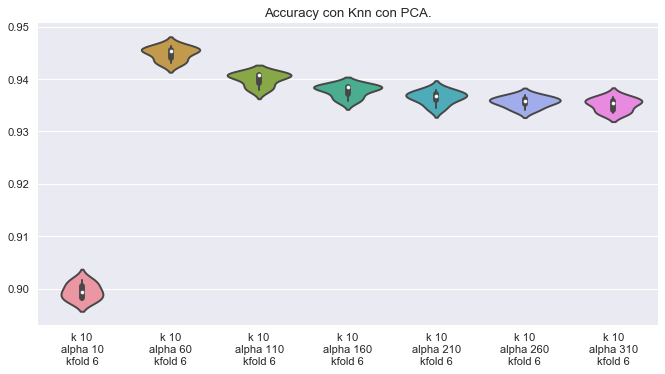

In [81]:

ac_pca = accuracy_metodos(nombres_pca, lista_metodos_pca)
knns = ac_pca.knn.unique()
print(knns)

for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.knn == k] 
    ac_aux = ac_aux[ac_aux.kfold == 6]
    print("alpha")
    graficar_orden_alpha(ac_aux, "Accuracy", "Knn con PCA", True)
    #print("kfold")
    #graficar_orden_kfold(ac_aux, "Accuracy", "Knn con PCA")



# calculamos F1 score

(esto es para mostrar lo que podemos hacer, es decir hice F1, pero podriamos haber hecho otra cosa)

## En este segmento vamos a calcular la F1 score M
### esto nos da un F1 score unificada para las 10 clases. es decir tenemos un valor por cada matriz que genera el kfold. Al tener un valor unificado, podemos ver como se comporta nuestros distintos algoritmos con un violin plot, de manera mas resumida. perdemos información, pero es mas fácil de disernir

                    mat0      mat1      mat2      mat3      mat4      mat5  \
k 2\nkfold 6    0.934253  0.930906  0.934807  0.929090  0.929831  0.929444   
k 10\nkfold 2   0.956443  0.957419       NaN       NaN       NaN       NaN   
k 14\nkfold 2   0.953583  0.953724       NaN       NaN       NaN       NaN   
k 10\nkfold 10  0.920781  0.924102  0.921260  0.919981  0.924705  0.925958   
k 14\nkfold 6   0.932471  0.930981  0.931197  0.928795  0.932035  0.931501   
k 6\nkfold 2    0.959989  0.959624       NaN       NaN       NaN       NaN   
k 2\nkfold 2    0.952489  0.951726       NaN       NaN       NaN       NaN   
k 10\nkfold 6   0.935533  0.934323  0.936579  0.933256  0.935444  0.935066   
k 6\nkfold 6    0.940667  0.938438  0.940740  0.937757  0.938921  0.939184   
k 6\nkfold 10   0.925644  0.928899  0.927899  0.925180  0.928405  0.929166   
k 2\nkfold 10   0.914799  0.920305  0.920303  0.915221  0.915971  0.919549   
k 14\nkfold 10  0.916245  0.919332  0.916050  0.915473  0.919710

/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


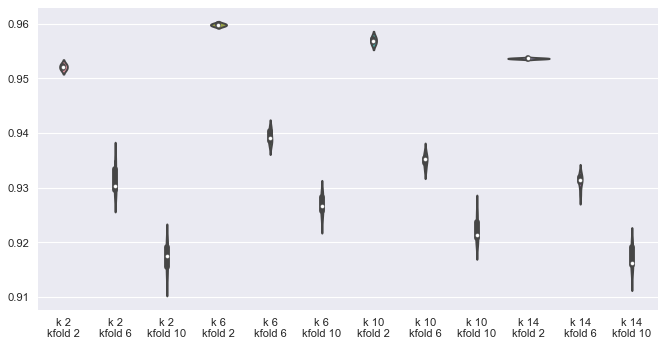

kfold


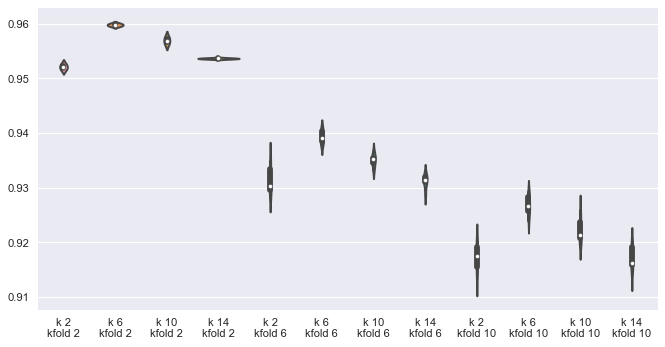

In [30]:
ac = F1_metodos(nombres, lista_metodos)
print("knn")
graficar_orden_knn(ac, "F1 score", "Knn")
print("kfold")
graficar_orden_kfold(ac, "F1 score", "Knn")

[14  2  6 10]
knn: 14
alpha


/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


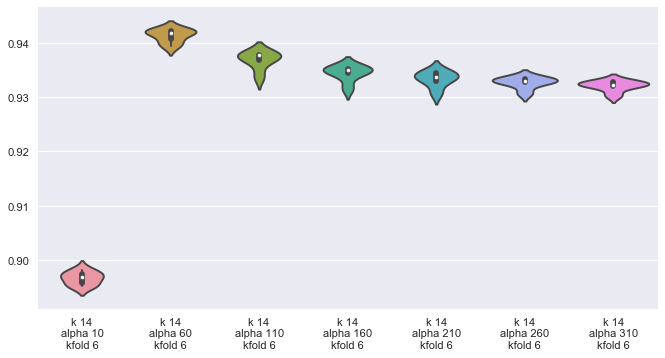

kfold


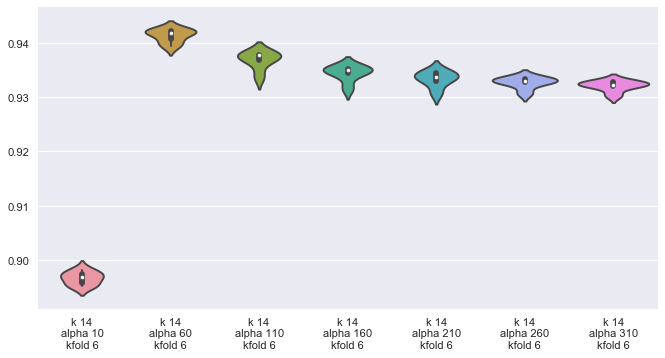

knn: 2
alpha


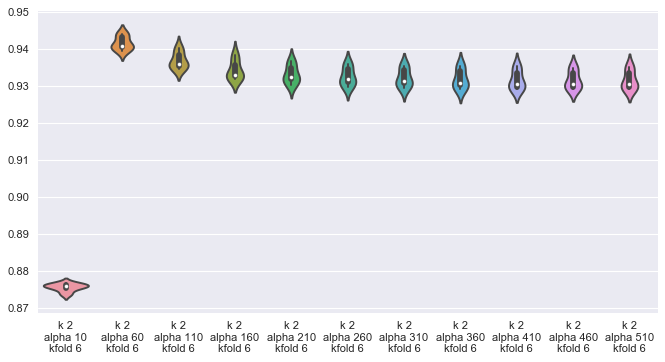

kfold


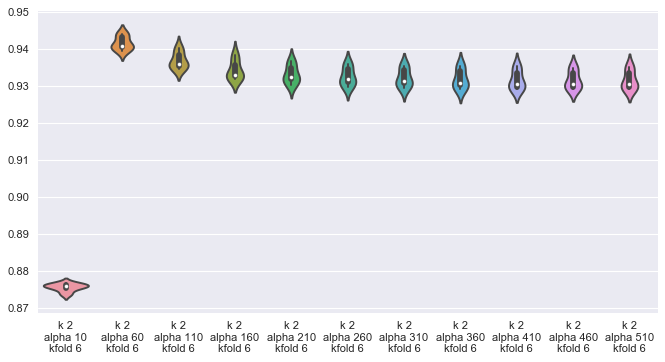

knn: 6
alpha


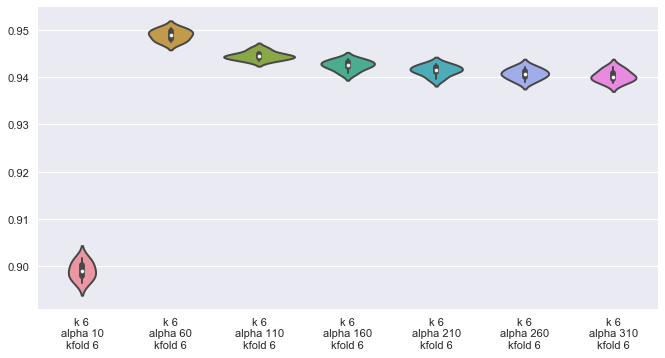

kfold


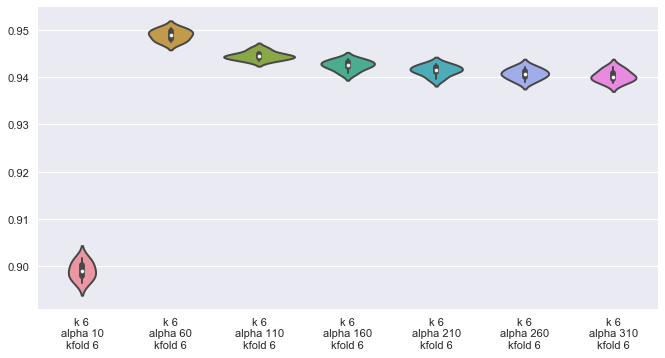

knn: 10
alpha


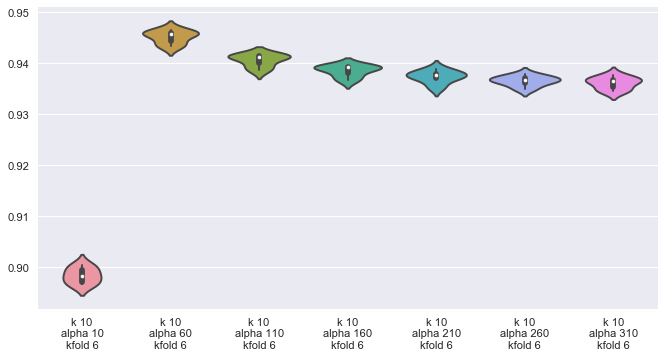

kfold


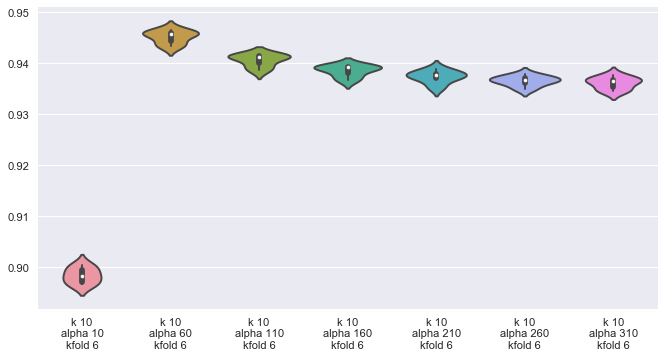

In [46]:
ac_pca = F1_metodos(nombres_pca, lista_metodos_pca)
knns = ac_pca.knn.unique()
print(knns)

for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.knn == k] 
    ac_aux = ac_aux[ac_aux.kfold == 6]
    print("alpha")
    graficar_orden_alpha(ac_aux)
    print("kfold")
    graficar_orden_kfold(ac_aux)

# nos quedamos con los preseleccionados.

### KNN = [6]
### KNNPCA = [(2, 60),(6, 60), (10, 60)]
### KNNMOD = []

In [56]:
#nombres_pca, lista_metodos_pca
#nombres, lista_metodos
nombres_preselec = []
lista_metodos_preselec = []
for i in range(len(nombres)):
    if(nombres[i][1] == 'k 6'):
        nombres_preselec.append(nombres[i])
        lista_metodos_preselec.append(lista_metodos[i])
        
        
for i in range(len(nombres_pca)):
    if(nombres_pca[i][2] == 'alpha 60'):
        nombres_preselec.append(nombres_pca[i])
        lista_metodos_preselec.append(lista_metodos_pca[i])
##falta lo de nico

knn


/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


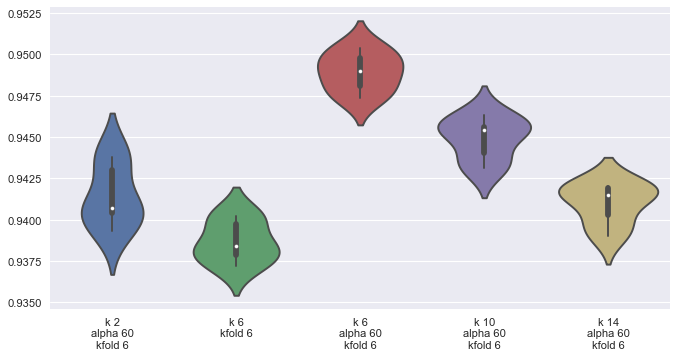

In [63]:
ac = accuracy_metodos(nombres_preselec, lista_metodos_preselec)
ac = ac[ac.kfold == 6]
print("knn")
graficar_orden_knn(ac)

/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


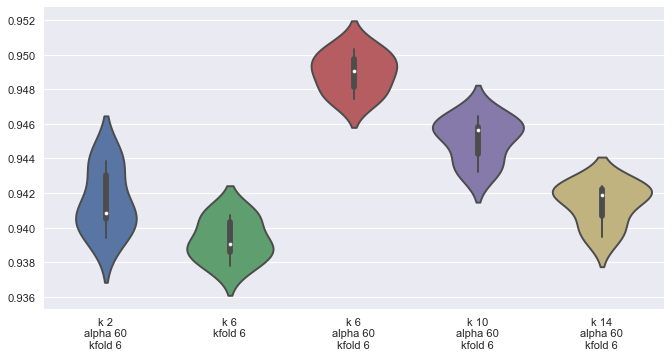

In [64]:
ac = F1_metodos(nombres_preselec, lista_metodos_preselec)
ac = ac[ac.kfold == 6]
graficar_orden_knn(ac)

In [67]:
print(type(lista_metodos_preselec))
print(type(lista_metodos_preselec[0]))
print(type(lista_metodos_preselec[0][0]))

<class 'list'>
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [82]:
def titulos(lista_variables):
    etiqueta = ''
    if lista_variables[0] == 'KNN':
        etiqueta +='Knn ' + str(lista_variables[1])
    if lista_variables[0] =='KNNPCA':
        etiqueta += 'Knn con PCA '+str(lista_variables[1])+' '+str(lista_variables[2])
    if lista_variables[0] == 'KNNMODPCA':
        etiqueta +='Knn modificado '+ str(lista_variables[2])
    etiqueta += ' '+ str(lista_variables[3])
    return etiqueta

RangeIndex(start=0, stop=10, step=1)


/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


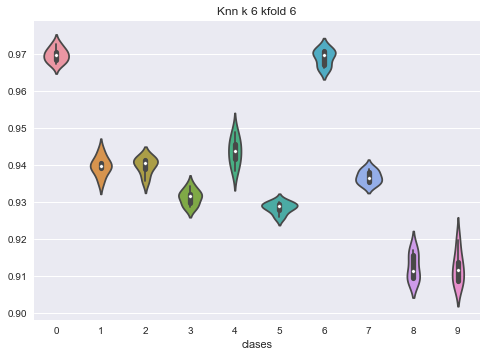

RangeIndex(start=0, stop=10, step=1)


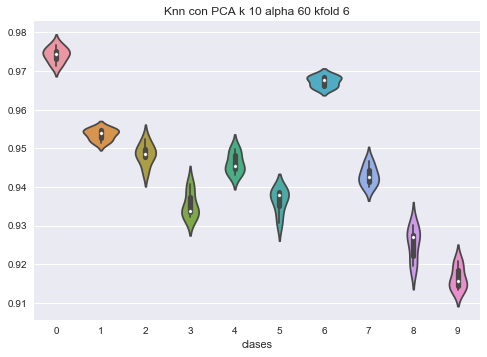

RangeIndex(start=0, stop=10, step=1)


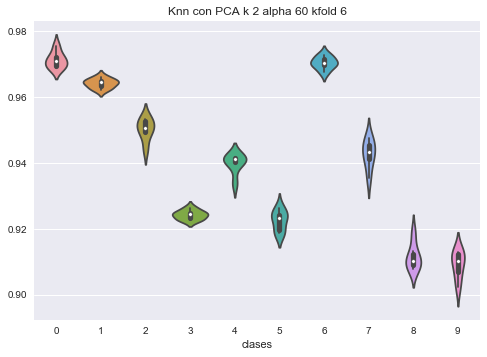

RangeIndex(start=0, stop=10, step=1)


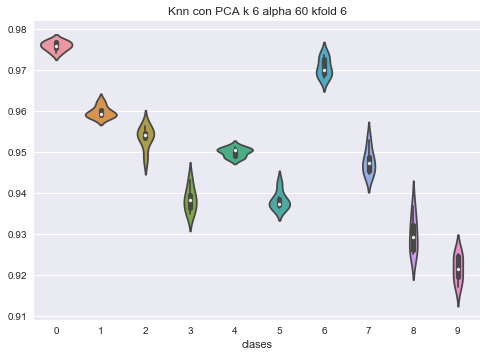

RangeIndex(start=0, stop=10, step=1)


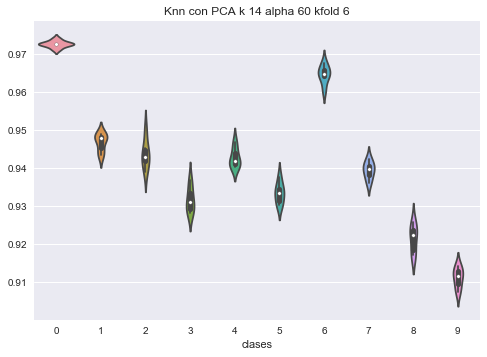

In [90]:

for i in range(len(nombres_preselec)):
    if(nombres_preselec[i][3] == 'kfold 6'):
        desvio, promedio, df = F_score_mat(1, lista_metodos_preselec[i])
        sns.violinplot(df.transpose())
        plt.xlabel("clases")
        plt.title(titulos(nombres_preselec[i]))
        plt.show()

/home/javier/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


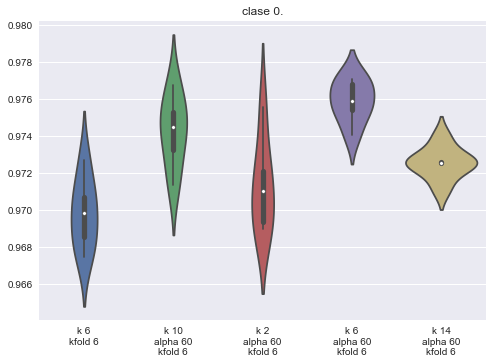

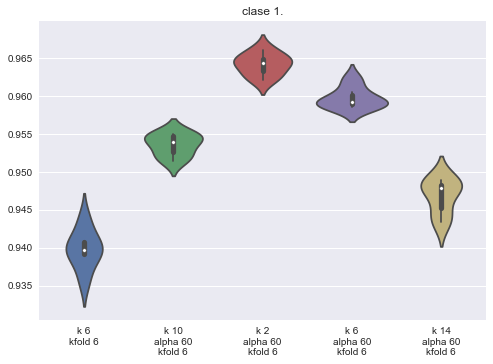

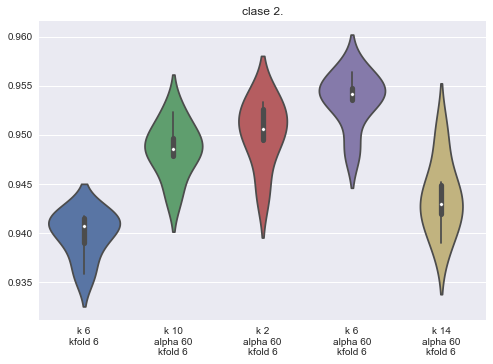

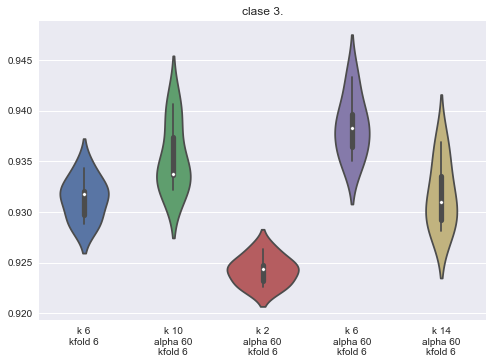

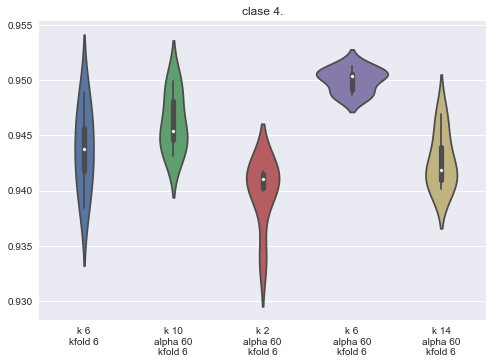

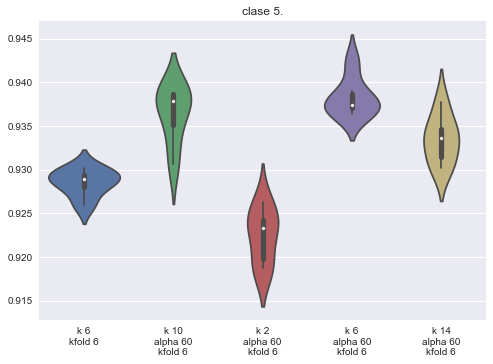

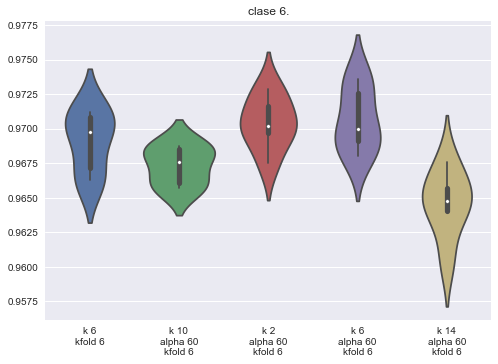

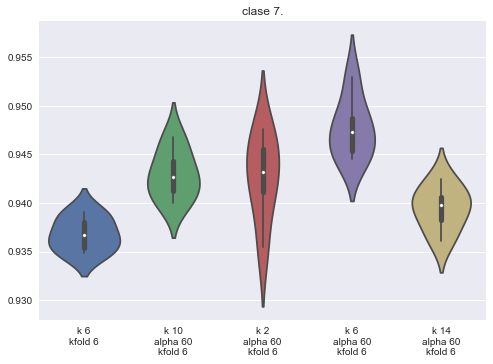

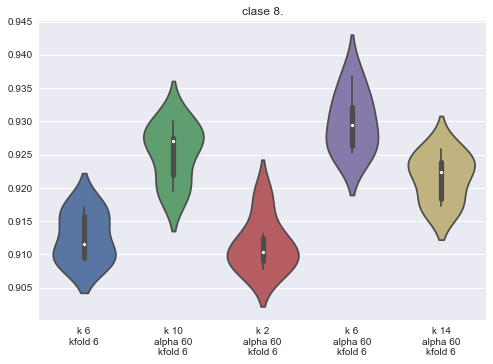

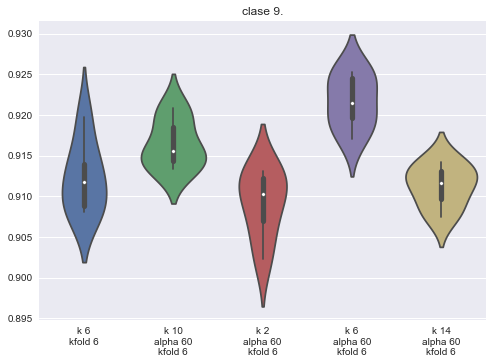

In [91]:
clases = [[] for x in range(10)]
etiquetas = []
for i in range(len(nombres_preselec)):
    if(nombres_preselec[i][3] == 'kfold 6'):
        desvio, promedio, df = F_score_mat(1, lista_metodos_preselec[i])
        etiqueta = tags(nombres_preselec[i])
        etiquetas.append(etiqueta)
        for j in df.index:
            aux = df.iloc[j].to_frame()
            clases[j].append(aux)
for i in range(10):
    data = pd.concat(clases[i], axis = 1)
    data.columns = etiquetas
    sns.violinplot(data)
    plt.title('clase '+str(i)+'.')
    plt.show()

### Como podemos observar, ningun metodo es superior a todos los demas para todas las clases. Esto nos deja

## ahora calcula mos el F1 score para cada clase

### esto nos deja ver el comportamiento de cada clase por separado, todavia no se que es mejor, tener graficos por clase y en ellos cada variante de nuestro algoritmo O tener graficos por algoritmos para ver como se comportan las calses en un algoritmo dado. Aunque estos graficos tengan escencialemente la misma información, se ven dos cosas distintas... asi que no se, por ahora voy a dejar las dos opciones

## grafico por algoritmo

In [ ]:

desvio, promedio, df = F_score_mat(1, matrices)
desvio, promedio_mod, df_mod = F_score_mat(1, mat_KNN_mod) 
desvio, promedio_knn, df_knn = F_score_mat(1, mat_KNN)


In [ ]:
sns.violinplot(df.transpose())
plt.title("alpha = 10?")
plt.show()
sns.violinplot(df_mod.transpose())
plt.title("modificado")
plt.show()
sns.violinplot(df_knn.transpose())
plt.title("knn")
plt.show()

## por clase

In [ ]:
for i in df.index:
    aux = df.iloc[i].to_frame()
    aux_mod = df_mod.iloc[i].to_frame()
    aux_knn = df_knn.iloc[i].to_frame()
    data = pd.concat([aux, aux_mod, aux_knn], axis = 1)
    data.columns = ['alpha = 10?', 'mod', 'knn']
    sns.violinplot(data)
    plt.title('clase '+str(i)+'.')
    plt.show()